## Import libraries

In [ ]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn,optim
from torch.utils.data import TensorDataset,DataLoader
from sklearn.metrics import f1_score,precision_score,recall_score,accuracy_score,confusion_matrix
from sklearn.preprocessing import LabelBinarizer
import pandas as pd
import seaborn as sns
import torch.nn.functional as F

## Download and Preprocess Dataset

In [ ]:
train_set = datasets.MNIST('/content',train=True,download=True)
test_set = datasets.MNIST('/content',train=False,download=True)
num_classes = 10

## Preprocessing

In [ ]:
# inversion and normalization
invert = lambda image : 1 - image # function to invert the image
normalize = lambda image : image / 255 # function for bringing pixel values in range [0,1]

def preprocessing(dataset):
    dataset_images = dataset.data.numpy() # convert the dataset into numpy array
    dataset_labels = dataset.targets.numpy() # convert the labels into numpy array
    dataset_images = normalize(dataset_images)
    dataset_images = invert(dataset_images)
    return dataset_images,dataset_labels

train_images,train_labels = preprocessing(train_set)
test_images,test_labels = preprocessing(test_set)

## Prepare the data

In [ ]:
def generate_labels(dataset_images,images_type):
  labels = np.zeros((dataset_images.shape[0],2))
  labels = np.full(shape=(dataset_images.shape[0],2),fill_value=[1-images_type,images_type],dtype=np.float32)
  return labels

# function to prepare the dataset for a given digit
def prepare_training_data(dataset_images,dataset_labels,class_num):
    indices = np.asarray(np.where(dataset_labels == class_num)) # indices of occurrence of digit as label
    indices = indices.flatten()
    # get the images for making positive dataset
    dataset_images_positive = dataset_images[indices] # images consisting of positive class
    dataset_labels_positive = generate_labels(dataset_images_positive,0) # generate the class labels
    print(dataset_images_positive.shape)
    # get the images for making negative dataset
    dataset_images_negative = invert(dataset_images_positive) # inverted images
    # print(dataset_images_negative.shape)
    dataset_labels_negative = generate_labels(dataset_images_negative,1)
    # concatenate the negative and positive datasets
    modified_dataset_images = np.concatenate((dataset_images_positive,dataset_images_negative))
    modified_dataset_labels = np.concatenate((dataset_labels_positive,dataset_labels_negative))
    tensor_x = torch.Tensor(modified_dataset_images)
    tensor_y = torch.Tensor(modified_dataset_labels)
    new_dataset = TensorDataset(tensor_x,tensor_y)
    return new_dataset

def prepare_testing_data(dataset_images,dataset_labels,class_num):
  positive_indices = np.asarray(np.where(dataset_labels == class_num)) # indices of occurrence of digit as label
  positive_indices = positive_indices.flatten()
  # get the images for making positive dataset
  dataset_images_positive = dataset_images[positive_indices] # images consisting of positive class
  dataset_labels_positive = generate_labels(dataset_images_positive,0) # generate the class labels
  print(dataset_images_positive.shape)
  # get the images for making negative classes for testing
  negative_indices = np.asarray(np.where(dataset_labels != class_num))
  negative_indices = negative_indices.flatten()
  # get the images for making negative dataset
  dataset_images_negative = dataset_images[negative_indices]
  dataset_labels_negative = generate_labels(dataset_images_negative,1)
  print(dataset_images_negative.shape)
  # concatenate the negative and positive datasets
  modified_dataset_images = np.concatenate((dataset_images_positive,dataset_images_negative))
  modified_dataset_labels = np.concatenate((dataset_labels_positive,dataset_labels_negative))
  tensor_x = torch.Tensor(modified_dataset_images)
  tensor_y = torch.Tensor(modified_dataset_labels)
  new_dataset = TensorDataset(tensor_x,tensor_y)
  return new_dataset

### Prepare the training set

In [ ]:
class_num = 6
batch_size = 64
train_class_set = prepare_training_data(train_images,train_labels,class_num) # fetch the training set for a class
test_class_set = prepare_testing_data(test_images,test_labels,class_num)
train_loader = DataLoader(train_class_set,batch_size=batch_size,shuffle=True)
test_loader = DataLoader(test_class_set,batch_size=batch_size) # take original testing set of all classes

(5918, 28, 28)


### Plotting some data

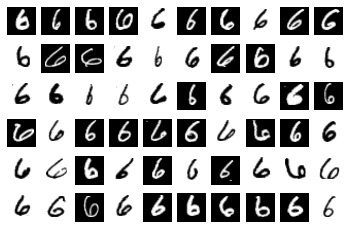

In [ ]:
dataiter = iter(train_loader)
images,labels = dataiter.next()
figure = plt.figure()
# print(labels)
num_of_images = 60
for index in range(1,num_of_images+1):
    plt.subplot(6,10,index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(),cmap='gray_r')

## Build the neural network

In [ ]:
# Model class
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 100)  # 4*4 from image dimension
        self.fc2 = nn.Linear(100, 10)
        self.fc3 = nn.Linear(10, 2)

    def forward(self, x):
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

epochs = 10
model = NeuralNetwork()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),lr=0.001,momentum=0.9)
# train the model
model.train()
for e in range(epochs):
  running_loss = 0.0
  for batch, (images,scores) in enumerate(train_loader):
    optimizer.zero_grad()
    # compute prediction error
    output = model(images)
    loss = criterion(output,scores)
    # Backpropagation
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
  else:
    print(f"Training loss: {running_loss/len(train_loader)}")
  

Training loss: 0.55818549459045
Training loss: 0.2760914888736364
Training loss: 0.04850567845073906
Training loss: 0.006159949751973555
Training loss: 0.0033531825895093985
Training loss: 0.002287984045373427
Training loss: 0.0017250671007393583
Training loss: 0.0013783454275186602
Training loss: 0.0011445656458129855
Training loss: 0.0009768019848805222


### Testing without a threshold

In [ ]:
def softmax(output):
  return torch.exp(output) / torch.sum(torch.exp(output),dim=1).view(-1,1)

# function to test without threshold
def test(dataloader,model):
  size = len(dataloader.dataset)
  model.eval()
  y_pred = []
  y_true = []
  with torch.no_grad():
    for images,scores in dataloader:
      output = model(images)
      output = softmax(output)
      for i in range(len(output)):
        yes_score = output[i][0]
        no_score = output[i][1]
        true_label = 1 if np.argmax(scores[i]) == 0 else 0
        pred_label = 1 if yes_score >= no_score else 0
        y_pred.append(pred_label)
        y_true.append(true_label)
  accuracy = accuracy_score(y_true,y_pred) # calculate the accuracy
  precision = precision_score(y_true,y_pred) # calculate precision
  recall = recall_score(y_true,y_pred) # calculate recall
  print(f"Accuracy : {(100*accuracy):>0.1f}%")
  print(f"Precision : {(100*precision):>0.1f}%")
  print(f"Recall : {(100*recall):>0.1f}%")
  print("Confusion Matrix: ")
  print(confusion_matrix(y_true,y_pred))

# output is of the form
# -------------
# | TN  | FP  |
# | FN  | TP  |
# -------------

test(test_loader,model)
data = np.empty((0,3),dtype=np.float32)

with torch.no_grad():
    for images,scores in test_loader:
      output = model(images)
      output = softmax(output)
      output = output.numpy()
      scores = scores.numpy()
      for i in range(len(output)):
        yes_score = output[i][0]
        no_score = output[i][1]
        true_label =  1 if np.argmax(scores[i]) == 0 else 0 
        # if true_label == 0:
        data = np.vstack((data,[[yes_score,no_score,true_label]]))
df = pd.DataFrame(data)
df.columns = ['yes_score','no_score','true_label']
df.describe()

Accuracy : 9.8%
Precision : 9.8%
Recall : 100.0%
Confusion Matrix: 
[[    0 63124]
 [    0  6876]]


,yes_score,no_score,true_label
count,70000.000000,70000.000000,70000.000000
mean,0.998063,0.001937,0.098229
std,0.003737,0.003737,0.297626
min,0.847301,0.000267,0.000000
25%,0.998185,0.000498,0.000000
50%,0.999299,0.000701,0.000000
75%,0.999502,0.001816,0.000000
max,0.999732,0.152699,1.000000


          yes_score      no_score    true_label
count  70000.000000  70000.000000  70000.000000
mean       0.998063      0.001937      0.098229
std        0.003737      0.003737      0.297626
min        0.847301      0.000267      0.000000
25%        0.998185      0.000498      0.000000
50%        0.999299      0.000701      0.000000
75%        0.999502      0.001816      0.000000
max        0.999732      0.152699      1.000000


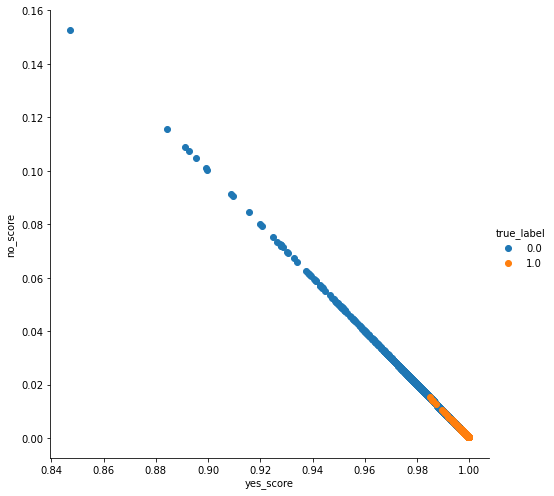

In [ ]:
print(df.describe())
sns.FacetGrid(df,hue="true_label",height=7).map(plt.scatter,"yes_score","no_score").add_legend()
plt.show()

## Testing

In [ ]:
# function to test the model on a given threshold
def test_with_threshold(dataloader,model,threshold):
  size = len(dataloader.dataset)
  model.eval()
  accuracy = 0
  y_true = [] # store the true class
  y_pred = [] # store the predicted class
  y_pred_score = []
  y_true_score = []
  with torch.no_grad():
      for images,logits in dataloader:
        output = model(images)
        output = softmax(output)
        outnp = output.numpy()
        logit_np = logits.numpy()
        for i in range(len(outnp)):
          true_label = 1 if logit_np[i][0] >= logit_np[i][1] else 0 # true class
          y_true.append(true_label)
          y_true_score.append(logit_np[i][0]) # true yes score
          y_pred_score.append(outnp[i][0]) # predicted yes score
          if outnp[i][0] >= threshold:
            y_pred.append(1) # predicted positive class
          else:
            y_pred.append(0) # predicted negative class
  accuracy = accuracy_score(y_true,y_pred) # calculate the accuracy
  precision = precision_score(y_true,y_pred) # calculate precision
  recall = recall_score(y_true,y_pred) # calculate recall
  return (accuracy,precision,recall)


threshold_data = np.empty((0,4),dtype=np.float32)

yes_scores = np.linspace(0.0,1.0,10,endpoint=False)
print(yes_scores)
for threshold in yes_scores:
  accuracy,precision,recall = test_with_threshold(test_loader,model,threshold)
  threshold_data = np.vstack((threshold_data,[[threshold,accuracy,precision,recall]]))


[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]


### Plotting the probability scores

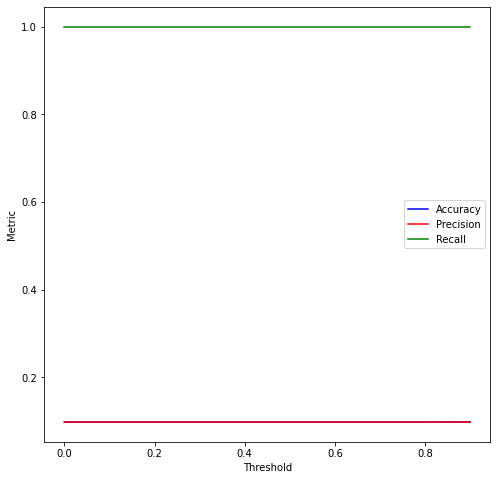

In [ ]:
plt.figure(figsize=(8,8))
plt.plot(threshold_data[:,0],threshold_data[:,1],c='b',label='Accuracy')
plt.plot(threshold_data[:,0],threshold_data[:,2],c='r',label='Precision')
plt.plot(threshold_data[:,0],threshold_data[:,3],c='g',label='Recall')
plt.legend()
plt.ylabel("Metric")
plt.xlabel("Threshold")
plt.show()